In [227]:
from other_function import load_object, RecurseListDir
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import cvxpy as cvx

In [228]:
NAMEPREFIX = "./result/20241122_224357"
N_FRAMES = 1
N_SLOTS = 1
N_RUS = 5
N_RBS = 3

RU_COLORS = ['red','orange', 'green', 'blue']
radius_in = 100                   
radius_out = 1000   

In [229]:
# LOAD DATA
G = load_object(f"{NAMEPREFIX}_physicalnet.pkl.gz")
coords_RUs = load_object(f"{NAMEPREFIX}_coords_RUs.pkl.gz")

coords_UEs_frames = []
solution_longterm_frames = []
coords_UEs_frames_slots = []
solution_shortterm_slots_frames = []
for f in range(N_FRAMES):
    coords_UEs_frames.append(
        load_object(f"{NAMEPREFIX}_coords_UEs_f{f}.pkl.gz")
    )
    solution_longterm_frames.append(
        load_object(f"{NAMEPREFIX}_solution_longterm_f{f}.pkl.gz")
    )
    coords_UEs_slots = []
    solution_shortterm_slots = []
    for t in range(N_SLOTS):
        coords_UEs_slots.append(
            load_object(f"{NAMEPREFIX}_coords_UEs_f{f}_t{t}.pkl.gz")
        )
        solution_shortterm_slots.append(
            load_object(f"{NAMEPREFIX}_solution_shortterm_f{f}_t{t}.pkl.gz")
        )
    coords_UEs_frames_slots.append(coords_UEs_slots)
    solution_shortterm_slots_frames.append(solution_shortterm_slots)

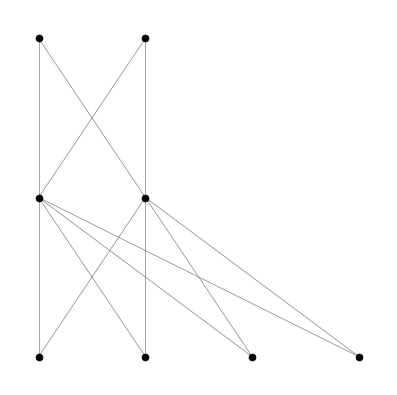

In [230]:
# NETWORK TOPO
x = 0
y = [100,50,0]
x_step = 50
count_CU = 0
count_DU = 0
count_RU = 0
loc = {}
for node in G.nodes:
    name = str(node)
    if name.startswith("CU"):
        loc_x = x + count_CU * x_step
        loc_y = y[0]
        count_CU += 1
        loc.update({name:(loc_x, loc_y)})
    if name.startswith("DU"):
        loc_x = x + count_DU * x_step
        loc_y = y[1]
        count_DU += 1
        loc.update({name:(loc_x, loc_y)})
    if name.startswith("RU"):
        loc_x = x + count_RU * x_step
        loc_y = y[2]
        count_RU += 1
        loc.update({name:(loc_x, loc_y)})
        
plt.figure(figsize=(10,10), dpi=50)
nx.draw_networkx(
    G, pos=loc,
    node_color="k",
    with_labels=False,
    edge_color="grey",
    node_shape="o",
    node_size=100
)
plt.box(False)
    # plt.savefig(f"{FIGPATH}/easy_{name}.pdf", bbox_inches="tight")
plt.show()

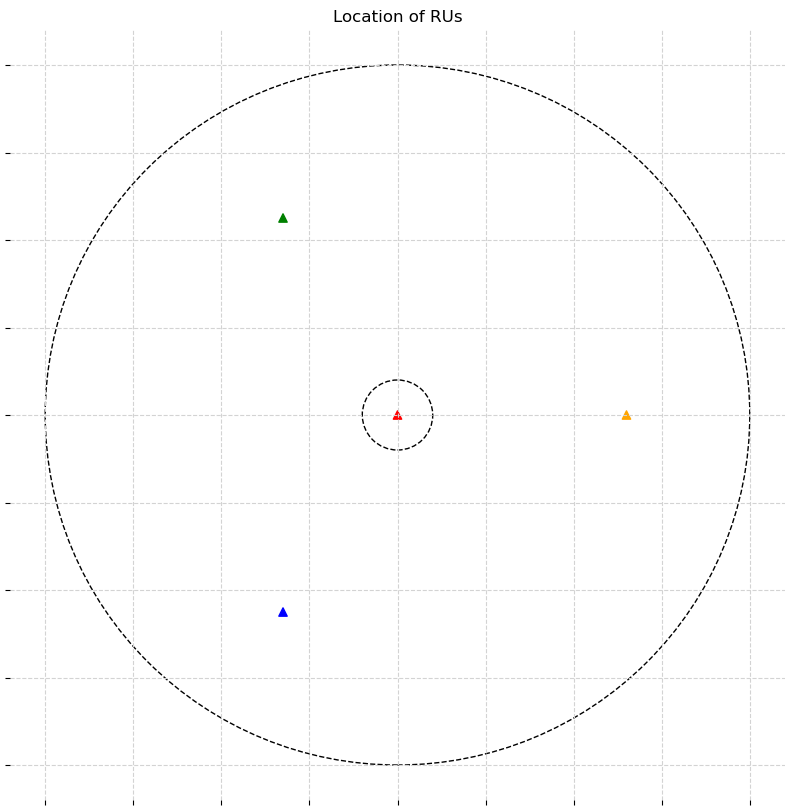

In [231]:
# RU LOCATIONS
def basemap(name="Location of RUs"):
    plt.figure(figsize=(10,10), dpi=100)
    ax = plt.gca()
    ax.cla()
    in_ras = plt.Circle((0,0), radius=radius_in, fill=False, linestyle="--")
    out_ras = plt.Circle((0,0), radius=radius_out, fill=False, linestyle="--")
    ax.add_patch(in_ras)
    ax.add_patch(out_ras)
    plt.scatter(
        [ru[0] for ru in coords_RUs],
        [ru[1] for ru in coords_RUs], 
        marker="^",
        c=RU_COLORS
    )
    ax.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.grid(color='lightgrey', linestyle='--', zorder=-100)
    plt.box(False)
    plt.title(name)
    
basemap()
plt.show()

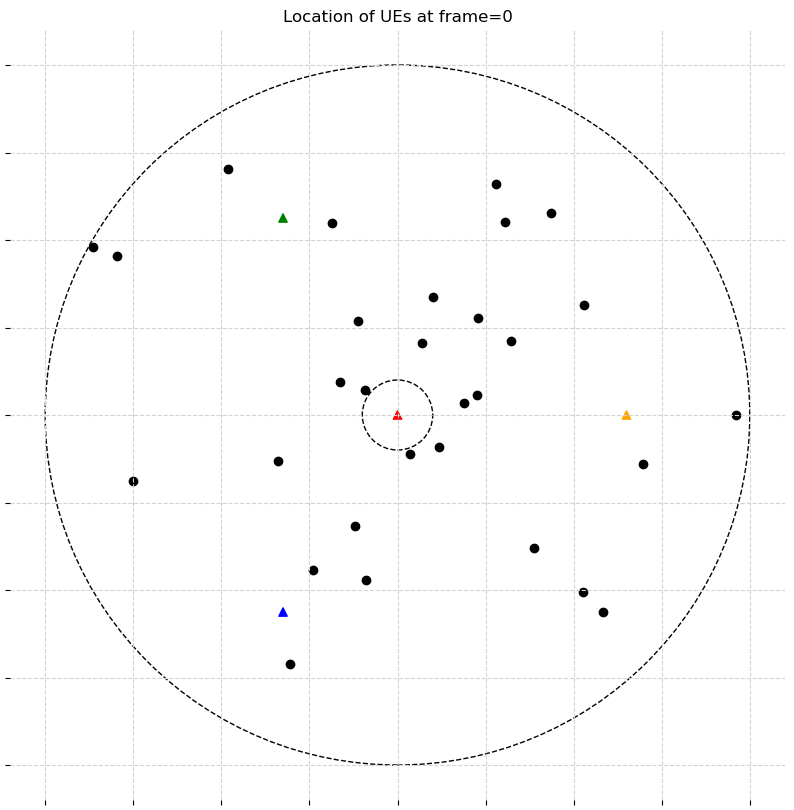

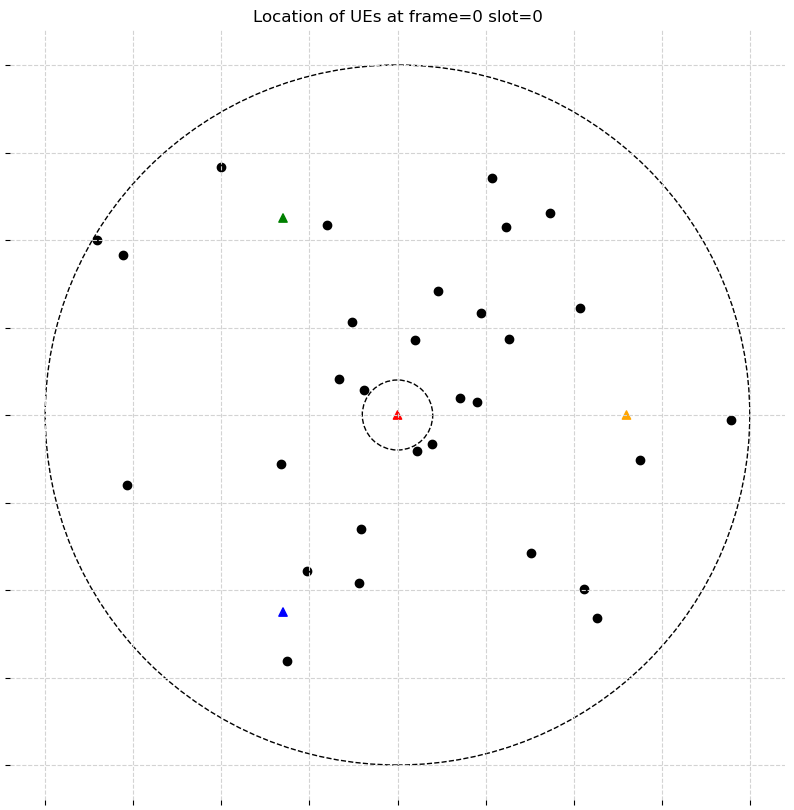

In [232]:
# LOCATIONS
for f in range(N_FRAMES):
    basemap(f"Location of UEs at frame={f}")
    plt.scatter(
        [ue[0] for ue in coords_UEs_frames[f]],
        [ue[1] for ue in coords_UEs_frames[f]],
        marker="o",
        c="k"
    )
    plt.show()
    for t in range(N_SLOTS):
        basemap(f"Location of UEs at frame={f} slot={t}")
        plt.scatter(
            [ue[0] for ue in coords_UEs_frames_slots[f][t]],
            [ue[1] for ue in coords_UEs_frames_slots[f][t]],
            marker="o",
            c="k"
        )
        plt.show()

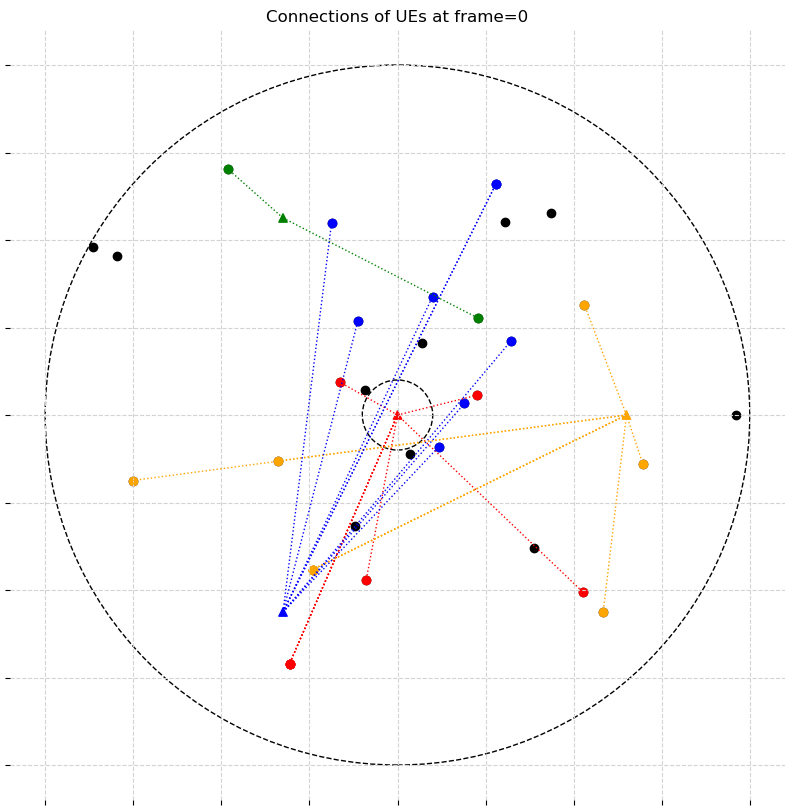

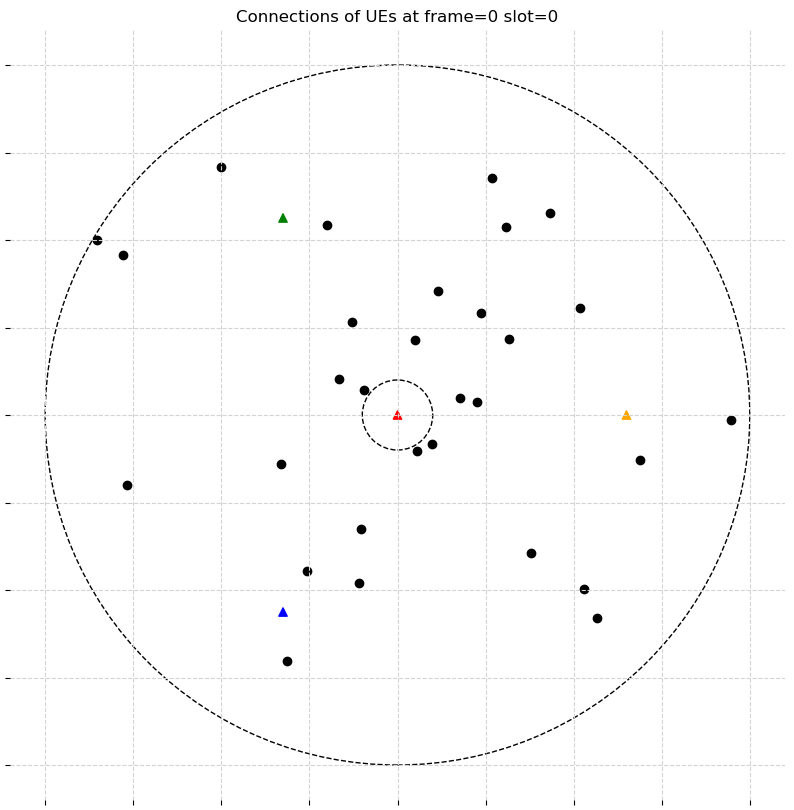

In [235]:
# CONNECTIONS
for f in range(N_FRAMES):
    basemap(f"Connections of UEs at frame={f}")
    plt.scatter(
        [ue[0] for ue in coords_UEs_frames[f]],
        [ue[1] for ue in coords_UEs_frames[f]],
        marker="o",
        c="k"
    )
    longterm_solution = solution_longterm_frames[f]
    pi_sk, z_ib_sk, p_ib_sk, mu_ib_sk, phi_i_sk, phi_j_sk, phi_m_sk = longterm_solution
    for i in range(len(z_ib_sk)):
        for b in range(len(z_ib_sk[i])):
            for s in range(len(z_ib_sk[i][b])):
                for k in range(len(z_ib_sk[i][b][s])):
                    if round(z_ib_sk[i,b,s,k].value) > 0:
                        x = [coords_RUs[i][0], coords_UEs_frames[f][k][0]]
                        y = [coords_RUs[i][1], coords_UEs_frames[f][k][1]]
                        plt.plot(x, y, linestyle="dotted", linewidth=1, c=RU_COLORS[i])
                        plt.scatter(coords_UEs_frames[f][k][0], coords_UEs_frames[f][k][1], c=RU_COLORS[i])
    plt.show()
    for t in range(N_SLOTS):
        basemap(f"Connections of UEs at frame={f} slot={t}")
        plt.scatter(
            [ue[0] for ue in coords_UEs_frames_slots[f][t]],
            [ue[1] for ue in coords_UEs_frames_slots[f][t]],
            marker="o",
            c="k"
        )
        shortterm_solution = solution_shortterm_slots_frames[f][t]
        short_pi_sk, short_z_ib_sk, short_p_ib_sk, short_mu_ib_sk = shortterm_solution
        for i in range(len(short_z_ib_sk)):
            for b in range(len(short_z_ib_sk[i])):
                for s in range(len(short_z_ib_sk[i][b])):
                    for k in range(len(short_z_ib_sk[i][b][s])):
                        if round(short_z_ib_sk[i,b,s,k].value) > 0:
                            x = [coords_RUs[i][0], coords_UEs_frames[f][k][0]]
                            y = [coords_RUs[i][1], coords_UEs_frames[f][k][1]]
                            plt.plot(x, y, linestyle="dotted", linewidth=1, c=RU_COLORS[i])
                            plt.scatter(coords_UEs_frames[f][k][0], coords_UEs_frames[f][k][1], c=RU_COLORS[i])
        plt.show()